In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import turingquant as tq

In [5]:
#Empresas Selecionadas para análise: Petrobras, BTG Pactual, Itaú Unibanco, Credit Suisse, Vivo e TIM
tickers = ['PETR4.SA', 'ITUB4.SA', 'HGLG11.SA', 'VIVT3.SA', 'TIMS3.SA']

In [6]:
df_close = yf.download(tickers, start='2019-01-01', end='2022-12-31')['Close']

[*********************100%***********************]  5 of 5 completed


In [7]:
df_close

,HGLG11.SA,ITUB4.SA,PETR4.SA,TIMS3.SA,VIVT3.SA
Date,,,,,
2019-01-02,140.899994,37.000000,24.059999,12.15,41.910000
2019-01-03,140.949997,37.610001,24.650000,11.92,41.400002
2019-01-04,140.250000,36.980000,24.719999,11.98,41.090000
2019-01-07,141.500000,37.049999,25.110001,12.37,41.200001
2019-01-08,142.000000,37.520000,24.959999,12.84,40.299999
...,...,...,...,...,...
2022-12-23,163.000000,25.190001,25.120001,12.30,38.459999
2022-12-26,163.990005,24.690001,24.940001,12.12,37.560001
2022-12-27,164.240005,24.549999,25.110001,12.23,37.410000


In [8]:
returns_pre = tq.metrics.returns(df_close)

In [9]:
returns = returns_pre[2:]

### Matrix Seriation: 
visa verificar o quão próximas as ações são umas das outras. Nesse sentido, foram escolhidas empresas do mesmo setor para verificar se o algoritmo é capaz de identificar potenciais semelhanças setoriais:
- Vivo e TIM: setor de telefonia
- Credit Suisse e Itaú: setor bancário

Para tanto, serão combinados um dendograma e uma matriz de covariância, como segue abaixo:

In [10]:
def matrix_seriation(returns):
    matriz_covarianca = returns.cov()
    dendograma = sns.clustermap(matriz_covarianca, method='ward', metric='euclidean')
    colunas_seriation = dendograma.dendrogram_col.reordered_ind
    colunas_seriation = returns.columns[colunas_seriation]
    return matriz_covarianca, colunas_seriation

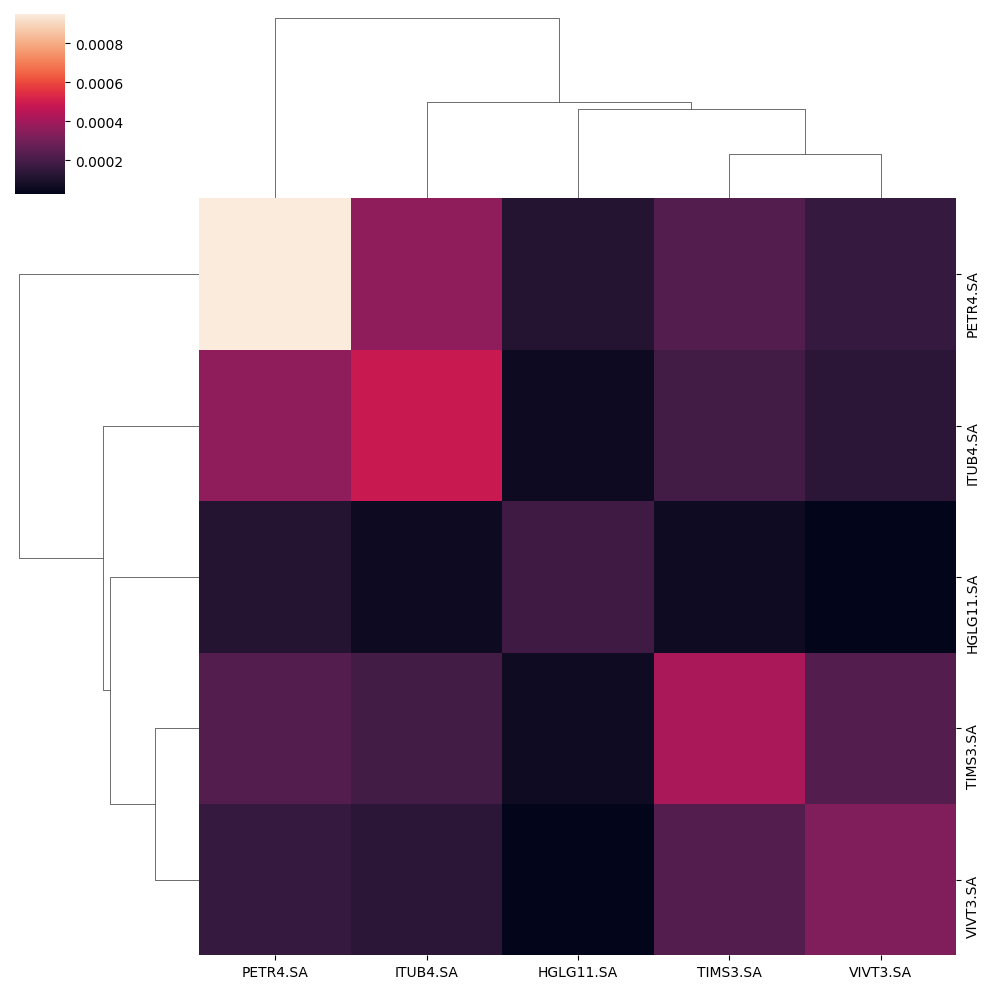

In [11]:
matriz_covarianca, colunas_seriation = matrix_seriation(returns)

In [13]:
matriz_covarianca

,HGLG11.SA,ITUB4.SA,PETR4.SA,TIMS3.SA,VIVT3.SA
HGLG11.SA,0.000183,0.000058,0.000118,0.000063,0.000028
ITUB4.SA,0.000058,0.000486,0.000360,0.000191,0.000136
PETR4.SA,0.000118,0.000360,0.000951,0.000228,0.000162
TIMS3.SA,0.000063,0.000191,0.000228,0.000419,0.000230
VIVT3.SA,0.000028,0.000136,0.000162,0.000230,0.000324


**Resultados:** fica evidenciada a capacidade de determinar a proximidade entre as ações, tanto pelo dendograma quanto pela matriz de covariância

### Calcula Pesos HRP:
Busca calcular os pesos ótimos de cada ativo considerado. Para isso, leva em conta o método HRP (Hierarchical Risk Parity), utilizando como base a clusterização hierárquica dos ativos e a matriz de covariância reorganizada de acordo com a clusterização obtida:

In [14]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

In [16]:
pesos = calcula_pesos_hrp(matriz_covarianca, colunas_seriation)

In [17]:
pesos

PETR4.SA     0.076507
ITUB4.SA     0.149869
HGLG11.SA    0.478116
TIMS3.SA     0.128978
VIVT3.SA     0.166530
dtype: float64

In [41]:
def backtest(df_close,pesos,valor_inicial=1e6):
    valor_a_investir = valor_inicial * pesos
    preco_inicial = df_close.iloc[0] # primeira data do df de preços é quando compramos
    qnt_acoes = np.ceil(valor_a_investir / preco_inicial) # aqui tem um arredondamento para cima, pois não é possível comprar um número quebrado de ações. Esse arredondamento pode ser feito de jeitos mais sofisticados
    return df_close.apply(lambda precos_dia: precos_dia*qnt_acoes,axis=1).sum(axis=1) # todos os dias calcula o valor que o portfolio tem para cada ação e soma

valor_portfolio = backtest(df_close,pesos)

<Axes: xlabel='Date'>

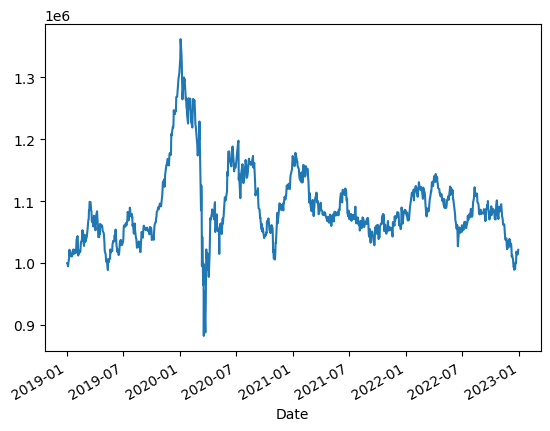

In [42]:
valor_portfolio.plot()